In [151]:
import numpy as np
import torch
import mnist_reader
import matplotlib.pyplot as plt
from scipy.special import expit
from numpy.linalg import inv, pinv
import pandas as pd

In [152]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

In [153]:
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')
X_train = X_train/255.0
X_test = X_test/255.0
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)
# pad the image for the bias
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))
print('X_train padded:', X_train.shape)
print('X_test padded:', X_test.shape)

('X_train:', (60000, 784))
('y_train:', (60000,))
('X_test:', (10000, 784))
('y_test:', (10000,))
('X_train padded:', (60000, 785))
('X_test padded:', (10000, 785))


In [154]:
labels = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

In [155]:
def visualize_sample():
    idx = 1
    for i in np.random.choice(60000, 10):
        img = X_train[i][:784].reshape(28,28)
        cls_idx = y_train[i]
        plt.subplot(1, 10, idx)
        plt.imshow(img)
        plt.axis('off')
        plt.title(labels[cls_idx])
        idx += 1
    plt.imshow(img)
    
def visualize_idx(idx, X, y):
    img = X[idx][:784].reshape(28,28)
    cls_idx = y[idx]
    plt.imshow(img)
    plt.title(labels[cls_idx])
    plt.imshow(img)

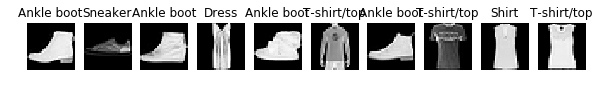

In [156]:
visualize_sample()

In [157]:
def train_val_split(X_train, y_train, val_size=0.05):
    # split train set into train and val set. split proportion will be according to val_size

    num_examples = len(y_train)
    val_indexes = np.random.choice(num_examples, int(num_examples * val_size), replace=False)

    X_val = X_train[val_indexes]
    y_val = y_train[val_indexes]

    # now get the remain indexes for train set
    mask = np.ones(num_examples, dtype=bool)
    mask[val_indexes] = False

    X_train = X_train[mask]
    y_train = y_train[mask]

    return X_train, X_val, y_train, y_val

In [158]:
#  X_train, X_val, y_train, y_val = train_val_split(X_train, y_train)

In [159]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_valid:', X_val.shape)
print('y_valid:', y_val.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

('X_train:', (60000, 785))
('y_train:', (60000,))


NameError: name 'X_val' is not defined

In [ ]:
visualize_idx(16, X_train, y_train)

In [ ]:
def data_loader(X, y, batch_size=100):
    assert X.shape[0] == len(y)
    for i in range(int(len(y)/batch_size)):
        yield X[i:i+batch_size], y[i:i+batch_size]

In [ ]:
# def sigmoid(X,theta):
#     a = np.dot(X, theta)
#     return expit(a)
def decision_boundary(prob):
    return 1 * (prob >= .5)

def sigmoid(X, theta):
    return 1.0 / (1 + np.exp(- np.matmul(X, theta)))

In [160]:
def thereshold(prob):
    return 1 * (prob >= .5)

In [161]:
def cross_entropy(X, y, theta):
    eps = 1e-9 # Prevent log(0)
    return - np.sum(np.multiply(y, np.log(sigmoid(X, theta) + eps)) + np.multiply((1 - y), np.log(1 - sigmoid(X, theta) + eps)))

In [162]:
def gradient(X, y, theta):
    N = X.shape[0]
    val = np.matmul(X.T, sigmoid(X, theta) - y) / N
    return val

In [163]:
def hessian(X, y, theta):
    sig = sigmoid(X, theta)
    R = np.diag(sig * (1 - sig))
    temp = np.matmul(X.T,R)
    hess = np.matmul(temp, X)
#     print(hess, hess.shape)
    return hess


In [164]:
# create sub-dataset
def create_sub_dataset(X_train, y_train, subset_idxs):
    mask = (y_train == subset_idxs[0])
    mask1 = (y_train == subset_idxs[1])
    train_length = mask.sum()
    X_train_true = X_train[mask]
    y_train_true = y_train[mask]
    X_train_false = X_train[mask1]
    y_train_false = y_train[mask1]
    # random choose negative sample
#     false_idx = np.random.choice(len(X_train_false),train_length, replace=False)
#     X_train_false = X_train_false[false_idx]
#     y_train_false = y_train_false[false_idx]
    # merge and shuffle
    X_train = np.concatenate((X_train_true, X_train_false),axis=0)
    y_train = np.concatenate((y_train_true, y_train_false),axis=0)
    randnum = np.random.randint(0,100)
    np.random.seed(randnum)
    np.random.shuffle(X_train)
    np.random.seed(randnum)
    np.random.shuffle(y_train)
    mask = (y_train == subset_idxs[0])
    temp = np.zeros_like(y_train)
    temp[mask] = 1
    y_train = temp
    
    return X_train, y_train
    
    
# y_train_subset = np.zeros_like(y_train)
# y_train_subset[mask] = 1
# mask = (y_val == subset_idx)
# y_val_subset = np.zeros_like(y_val)
# y_val_subset[mask] = 1
# mask = (y_test == subset_idx)
# y_test_subset = np.zeros_like(y_test)
# y_test_subset[mask] = 1

In [165]:
def test(classifier, x_test, y_test):
    y_pred = decision_boundary(sigmoid(x_test, classifier))
    
    # Create confusion matrix.
    cm = np.zeros((2, 2), dtype=int)
    np.add.at(cm, [y_test, y_pred], 1)

    print("== Confusion Matrix ==")
    print(cm)
    print("== Accuracy ==")
    print((y_test == y_pred).sum()/float(len(y_pred)))

In [166]:
# first order method 

X_train, y_train = create_sub_dataset(X_train, y_train, [3,5])
X_test, y_test = create_sub_dataset(X_test, y_test, [3,5])

In [167]:
theta = np.random.normal(0,1,X_train.shape[1]) # 785 x 1 initialize
# start training
lr = 0.5
epochs = 10
for epoch in range(epochs):
    empirical_loss = 0
    count = 0
    train_loader = data_loader(X_train, y_train, 12000)

    for X, y in train_loader:
        loss = cross_entropy(X, y, theta)
        grad = gradient(X, y, theta)
#         hess = hessian(X, y, theta)
        theta -= lr*grad
        empirical_loss += loss
        count += len(y)

    test(theta, X_test, y_test)    
    empirical_loss /= count
    print("epoch: {}, empirical loss: {}".format(epoch,empirical_loss))

== Confusion Matrix ==
[[408 592]
 [ 29 971]]
== Accuracy ==
0.6895
epoch: 0, empirical loss: 2.75558602365
== Confusion Matrix ==
[[748 252]
 [136 864]]
== Accuracy ==
0.806
epoch: 1, empirical loss: 1.41328677066
== Confusion Matrix ==
[[811 189]
 [ 78 922]]
== Accuracy ==
0.8665
epoch: 2, empirical loss: 0.62317985384
== Confusion Matrix ==
[[856 144]
 [ 66 934]]
== Accuracy ==
0.895
epoch: 3, empirical loss: 0.438139769825
== Confusion Matrix ==
[[877 123]
 [ 59 941]]
== Accuracy ==
0.909
epoch: 4, empirical loss: 0.342179942799
== Confusion Matrix ==
[[887 113]
 [ 51 949]]
== Accuracy ==
0.918
epoch: 5, empirical loss: 0.283740124463
== Confusion Matrix ==
[[896 104]
 [ 44 956]]
== Accuracy ==
0.926
epoch: 6, empirical loss: 0.244256216181
== Confusion Matrix ==
[[905  95]
 [ 41 959]]
== Accuracy ==
0.932
epoch: 7, empirical loss: 0.215690659442
== Confusion Matrix ==
[[910  90]
 [ 37 963]]
== Accuracy ==
0.9365
epoch: 8, empirical loss: 0.193980745485
== Confusion Matrix ==
[[920

In [168]:
test(theta, X_test, y_test)

== Confusion Matrix ==
[[920  80]
 [ 35 965]]
== Accuracy ==
0.9425


In [170]:
# second order method 
randnum = np.random.randint(0,100)
np.random.seed(randnum)
print(randnum)
theta = np.random.normal(0,1,X_train.shape[1]) # 785 x 1 initialize
# start training
epochs = 10
for epoch in range(epochs):
    empirical_loss = 0
    count = 0
    train_loader = data_loader(X_train, y_train, 12000)

    for X, y in train_loader:
        loss = cross_entropy(X, y, theta)
        grad = gradient(X, y, theta)
        hess = hessian(X, y, theta)
        try:
            theta -= np.matmul(inv(hess),grad)
        except:
            theta -= np.matmul(pinv(hess),grad)

        empirical_loss += loss
        count += len(y)

    test(theta, X_test, y_test)    
    empirical_loss /= count
    print("epoch: {}, empirical loss: {}".format(epoch,empirical_loss))

7


KeyboardInterrupt: 

In [171]:
data = pd.read_csv('data/iris.data.txt')
#     break
# print(data)

X_train, y_train = [], []
for i in range(len(data)):
    temp = list(data.loc[i])
    name = temp[4]
    if name == 'Iris-setosa':
        X_train.append(temp[:-1])
        y_train.append(0)
    if name == 'Iris-virginica':
        X_train.append(temp[:-1])
        y_train.append(1)
        
X_train = np.array(X_train)
y_train = np.array(y_train, dtype=int)
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))
print('X_train:', X_train.shape)

('X_train:', (99, 5))


In [172]:
randnum = np.random.randint(0,100)
np.random.seed(randnum)
np.random.shuffle(X_train)
np.random.seed(randnum)
np.random.shuffle(y_train)

In [173]:
X_train

array([[ 7.7,  3. ,  6.1,  2.3,  1. ],
       [ 6.4,  3.2,  5.3,  2.3,  1. ],
       [ 5.8,  2.8,  5.1,  2.4,  1. ],
       [ 7.4,  2.8,  6.1,  1.9,  1. ],
       [ 5. ,  3.4,  1.5,  0.2,  1. ],
       [ 4.3,  3. ,  1.1,  0.1,  1. ],
       [ 5.1,  3.8,  1.9,  0.4,  1. ],
       [ 5.7,  3.8,  1.7,  0.3,  1. ],
       [ 4.4,  2.9,  1.4,  0.2,  1. ],
       [ 4.9,  3.1,  1.5,  0.1,  1. ],
       [ 4.8,  3. ,  1.4,  0.3,  1. ],
       [ 4.9,  3.1,  1.5,  0.1,  1. ],
       [ 6. ,  3. ,  4.8,  1.8,  1. ],
       [ 4.9,  3.1,  1.5,  0.1,  1. ],
       [ 5.1,  3.4,  1.5,  0.2,  1. ],
       [ 5.1,  3.5,  1.4,  0.3,  1. ],
       [ 6.7,  3.3,  5.7,  2.5,  1. ],
       [ 5. ,  3. ,  1.6,  0.2,  1. ],
       [ 6.1,  2.6,  5.6,  1.4,  1. ],
       [ 5.7,  4.4,  1.5,  0.4,  1. ],
       [ 4.9,  2.5,  4.5,  1.7,  1. ],
       [ 7.7,  2.6,  6.9,  2.3,  1. ],
       [ 5.3,  3.7,  1.5,  0.2,  1. ],
       [ 7.9,  3.8,  6.4,  2. ,  1. ],
       [ 7.2,  3. ,  5.8,  1.6,  1. ],
       [ 4.6,  3.4,  1.4,

In [174]:
y_train

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0])

In [176]:
# first order
np.random.seed(randnum)
theta = np.random.normal(0,1,X_train.shape[1]) # 785 x 1 initialize
# start training
lr = 0.01
epochs = 100
for epoch in range(epochs):
    empirical_loss = 0
    count = 0
    train_loader = data_loader(X_train, y_train, 99)

    for X, y in train_loader:
        loss = cross_entropy(X, y, theta)
        grad = gradient(X, y, theta)
#         hess = hessian(X, y, theta)
        theta -= lr*grad
        empirical_loss += loss
        count += len(y)
        
    test(theta, X_train, y_train)

#     test(theta, X_test, y_test)    
    empirical_loss /= count
    print("epoch: {}, empirical loss: {}".format(epoch,empirical_loss))

== Confusion Matrix ==
[[ 0 49]
 [ 0 50]]
== Accuracy ==
0.505050505051
epoch: 0, empirical loss: 0.781298021359
== Confusion Matrix ==
[[ 0 49]
 [ 0 50]]
== Accuracy ==
0.505050505051
epoch: 1, empirical loss: 0.741410757436
== Confusion Matrix ==
[[ 0 49]
 [ 0 50]]
== Accuracy ==
0.505050505051
epoch: 2, empirical loss: 0.706509594158
== Confusion Matrix ==
[[ 0 49]
 [ 0 50]]
== Accuracy ==
0.505050505051
epoch: 3, empirical loss: 0.676258938375
== Confusion Matrix ==
[[ 0 49]
 [ 0 50]]
== Accuracy ==
0.505050505051
epoch: 4, empirical loss: 0.650237539062
== Confusion Matrix ==
[[ 0 49]
 [ 0 50]]
== Accuracy ==
0.505050505051
epoch: 5, empirical loss: 0.627971287474
== Confusion Matrix ==
[[ 1 48]
 [ 0 50]]
== Accuracy ==
0.515151515152
epoch: 6, empirical loss: 0.608966198631
== Confusion Matrix ==
[[ 1 48]
 [ 0 50]]
== Accuracy ==
0.515151515152
epoch: 7, empirical loss: 0.592737249853
== Confusion Matrix ==
[[ 1 48]
 [ 0 50]]
== Accuracy ==
0.515151515152
epoch: 8, empirical loss

In [177]:
# second order
np.random.seed(randnum)
theta = np.random.normal(0,1,X_train.shape[1]) # 785 x 1 initialize
# start training
lr = 0.5
epochs = 1000
for epoch in range(epochs):
    empirical_loss = 0
    count = 0
    train_loader = data_loader(X_train, y_train, 99)

    for X, y in train_loader:
        loss = cross_entropy(X, y, theta)
        grad = gradient(X, y, theta)
        hess = hessian(X, y, theta)
        try:
            theta -= np.matmul(inv(hess),grad)
        except:
            print('singular')
            theta -= np.matmul(pinv(hess),grad)
        empirical_loss += loss
        count += len(y)

    test(theta, X_train, y_train)  
    empirical_loss /= count
    print("epoch: {}, empirical loss: {}".format(epoch,empirical_loss))

== Confusion Matrix ==
[[ 0 49]
 [ 0 50]]
== Accuracy ==
0.505050505051
epoch: 0, empirical loss: 0.781298021359
== Confusion Matrix ==
[[ 0 49]
 [ 0 50]]
== Accuracy ==
0.505050505051
epoch: 1, empirical loss: 0.764041246028
== Confusion Matrix ==
[[ 0 49]
 [ 0 50]]
== Accuracy ==
0.505050505051
epoch: 2, empirical loss: 0.747515423106
== Confusion Matrix ==
[[ 0 49]
 [ 0 50]]
== Accuracy ==
0.505050505051
epoch: 3, empirical loss: 0.731666541638
== Confusion Matrix ==
[[ 0 49]
 [ 0 50]]
== Accuracy ==
0.505050505051
epoch: 4, empirical loss: 0.716446356818
== Confusion Matrix ==
[[ 0 49]
 [ 0 50]]
== Accuracy ==
0.505050505051
epoch: 5, empirical loss: 0.701811597416
== Confusion Matrix ==
[[ 0 49]
 [ 0 50]]
== Accuracy ==
0.505050505051
epoch: 6, empirical loss: 0.687723304866
== Confusion Matrix ==
[[ 0 49]
 [ 0 50]]
== Accuracy ==
0.505050505051
epoch: 7, empirical loss: 0.674146278611
== Confusion Matrix ==
[[ 0 49]
 [ 0 50]]
== Accuracy ==
0.505050505051
epoch: 8, empirical loss

[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 116, empirical loss: 0.151870920851
== Confusion Matrix ==
[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 117, empirical loss: 0.1501583162
== Confusion Matrix ==
[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 118, empirical loss: 0.148467571455
== Confusion Matrix ==
[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 119, empirical loss: 0.146798343362
== Confusion Matrix ==
[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 120, empirical loss: 0.145150295748
== Confusion Matrix ==
[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 121, empirical loss: 0.143523099328
== Confusion Matrix ==
[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 122, empirical loss: 0.14191643152
== Confusion Matrix ==
[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 123, empirical loss: 0.140329976266
== Confusion Matrix ==
[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 124, empirical loss: 0.138763423859
== Confusion Matrix ==
[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 125, empirical loss: 0

1.0
epoch: 362, empirical loss: 0.0116265023943
== Confusion Matrix ==
[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 363, empirical loss: 0.0115097486809
== Confusion Matrix ==
[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 364, empirical loss: 0.0113941778505
== Confusion Matrix ==
[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 365, empirical loss: 0.0112797777078
== Confusion Matrix ==
[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 366, empirical loss: 0.0111665361874
== Confusion Matrix ==
[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 367, empirical loss: 0.0110544413525
== Confusion Matrix ==
[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 368, empirical loss: 0.0109434813935
== Confusion Matrix ==
[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 369, empirical loss: 0.0108336446262
== Confusion Matrix ==
[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 370, empirical loss: 0.0107249194907
== Confusion Matrix ==
[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 371, empirical loss: 0.0106172945502
== Conf

== Accuracy ==
1.0
epoch: 667, empirical loss: 0.000545334660865
== Confusion Matrix ==
[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 668, empirical loss: 0.00053990304475
== Confusion Matrix ==
[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 669, empirical loss: 0.000534525537768
== Confusion Matrix ==
[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 670, empirical loss: 0.000529201600533
== Confusion Matrix ==
[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 671, empirical loss: 0.000523930699046
== Confusion Matrix ==
[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 672, empirical loss: 0.000518712304639
== Confusion Matrix ==
[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 673, empirical loss: 0.000513545893919
== Confusion Matrix ==
[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 674, empirical loss: 0.000508430948723
== Confusion Matrix ==
[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 675, empirical loss: 0.000503366956056
== Confusion Matrix ==
[[49  0]
 [ 0 50]]
== Accuracy ==
1.0
epoch: 676, empiric